<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37 - Part 2: Regression Benchmarking & Optimization</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

---
## Table of Contents

1. [Setup & Data Loading](#1-setup)
2. [Feature Selection](#2-feature-selection)
   - 2.1 Feature Removal from Part 1
   - 2.2 Variance Threshold
   - 2.3 Correlation Analysis
   - 2.4 Statistical Hypothesis Testing
   - 2.5 Model-Based Feature Importance
   - 2.6 Optimal Feature Set Selection
3. [Regression Benchmarking](#3-benchmarking)
   - 3.1 Evaluation Function
   - 3.2 Model Selection Strategy & Metrics
   - 3.3 Model Configuration & Hyperparameter Search
   - 3.4 Benchmarking Results
   - 3.5 Model Selection Results
4. [Model Optimization](#4-optimization)
   - 4.1 Stacking Ensemble
   - 4.2 Weighted Average Ensemble
   - 4.3 Model Interpretability (LIME)
5. [Deployment](#5-deployment)

---

<a id='1-setup'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>1 | Setup & Data Loading</b></span>
    </h1>
</div>

We load the preprocessed datasets from Part 1 and prepare them for model training. Log-transformed target arrays are created to reduce the impact of price outliers. A combined training set (train + validation) is prepared for final model training before Kaggle submission.

### 1.1 Import Libraries

In [64]:
# =========================
# Standard library
# =========================
import random
from itertools import combinations, product

# =========================
# Data manipulation
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# =========================
# Statistics / Optimization
# =========================
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import ttest_ind, chi2_contingency, f_oneway

# =========================
# Scikit-learn - Base / Model selection
# =========================
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid

# =========================
# Scikit-learn - Feature Selection
# =========================
from sklearn.feature_selection import (
    VarianceThreshold,
    RFE,
    SelectKBest,
    mutual_info_regression,
)

# =========================
# Scikit-learn - Models
# =========================
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    StackingRegressor,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# =========================
# Scikit-learn - Metrics
# =========================
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    mean_pinball_loss,
    make_scorer,
)

# =========================
# MLxtend
# =========================
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# =========================
# Explainability
# =========================
import lime
import lime.lime_tabular

# =========================
# Utilities / Persistence
# =========================
import joblib
import utils

# =========================
# Plot style
# =========================
palette = ['#5C4212', '#a92f02', '#a55b1bf9', '#b08972', '#e3a76c', '#e5c120', '#f39c06', '#f2e209']

# =========================
# Reproducibility
# =========================
random.seed(37)
np.random.seed(37)


### 1.2 Load Data

In [22]:
# Load the datasets (train, validation, test)
X_train_scaled = pd.read_parquet("./project_data/X_train_scaled.parquet", engine="pyarrow")
X_val_scaled   = pd.read_parquet("./project_data/X_val_scaled.parquet",   engine="pyarrow")
X_test_scaled  = pd.read_parquet("./project_data/X_test_scaled.parquet",  engine="pyarrow")

y_train = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

# Set carID as index
X_train_scaled, X_val_scaled, X_test_scaled = [d.set_index('carID') for d in (X_train_scaled, X_val_scaled, X_test_scaled)]
y_train, y_val = [d.set_index('carID') for d in (y_train, y_val)]

print(f"Train: {X_train_scaled.shape[0]:,} rows, {X_train_scaled.shape[1]} features")
print(f"Val:   {X_val_scaled.shape[0]:,} rows")
print(f"Test:  {X_test_scaled.shape[0]:,} rows")

Train: 60,768 rows, 37 features
Val:   15,193 rows
Test:  32,567 rows


In [23]:
# Target arrays
y_train_array = y_train['price'].values if isinstance(y_train, pd.DataFrame) else y_train.values.ravel()
y_val_array   = y_val['price'].values if isinstance(y_val, pd.DataFrame) else y_val.values.ravel()

# Log transformation of target (reduces impact of outliers)
y_train_log = np.log1p(y_train_array)
y_val_log   = np.log1p(y_val_array)

# Combined train+val for final model training
X_train_full_scaled   = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_full_array    = np.concatenate([y_train_array, y_val_array])
y_train_full_log      = np.concatenate([y_train_log, y_val_log])

print(f"Train samples: {len(y_train_array):,}")
print(f"Val samples:   {len(y_val_array):,}")
print(f"Full samples:  {len(y_train_full_array):,}")

Train samples: 60,768
Val samples:   15,193
Full samples:  75,961


<a id='2-feature-selection'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2 | Feature Selection</b></span>
    </h1>
</div>

Feature selection reduces dimensionality, mitigates overfitting, and improves interpretability. We apply a multi-method approach:

1. **Business-Based Removal**: Exclude features unavailable at prediction time (paintQuality%)
2. **Variance Threshold**: Remove near-constant features (variance ≤ 0.01)
3. **Correlation Analysis**: Identify features with weak target relationships
4. **Statistical Testing**: F-regression tests for predictive significance
5. **Model-Based Selection**: Tree importance and Lasso coefficients

The final feature set balances predictive power with model parsimony.

### 2.1 Feature Removal from Part 1

In Part 1 (Data Preprocessing), we already removed the following features:
- **`year`**: Replaced by derived features (`age`, `age_squared`, `is_new_car`, `is_old_car`)
- **`model`**: Encoded via target encoding (`model_mean_price`, `model_popularity`)
- **`paintQuality%`**: Not available at prediction time (filled by mechanic during evaluation)

We now proceed with additional feature selection techniques on the remaining 37 features.

### 2.2 Variance Threshold

We apply a variance threshold filter to remove features with near-zero variance, as they provide little discriminative power for prediction.

In [24]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
X_train_sel = vart.fit(X_train_scaled)

# Get low variance columns and print them
low_variance = X_train_scaled.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train_scaled.columns.get_loc(col)]:.4f}")

# Drop low variance columns from train, val and test sets
X_train_scaled = X_train_scaled.drop(columns=low_variance, errors='ignore')
X_val_scaled = X_val_scaled.drop(columns=low_variance, errors='ignore')
X_test_scaled = X_test_scaled.drop(columns=low_variance, errors='ignore')

Number of features with variance closer to zero: 4
Features with variance closer to zero:
hasDamage: 0.0000
transmission_other: 0.0000
fuelType_electric: 0.0001
fuelType_other: 0.0022


### 2.3 Correlation Analysis with Target

We compute Spearman correlation coefficients between each feature and the target variable (log-transformed price) to identify the less relevant predictors.

In [25]:
# Correlação de cada feature com o target (price)
cor_with_target = pd.concat([
    X_train_scaled, 
    pd.Series(y_train_log, index=X_train_scaled.index, name='price')
], axis=1).corr(method='spearman')['price'].drop('price')

# Criar DataFrame ordenado por valor absoluto
cor_df = pd.DataFrame({
    'Feature': cor_with_target.index,
    'Correlation': cor_with_target.values,
    'Abs_Correlation': np.abs(cor_with_target.values)
}).sort_values('Abs_Correlation', ascending=False).reset_index(drop=True)

# Mostrar
print("=== Correlation with Price (Spearman) ===")
display(cor_df)

# Destacar features com baixa correlação (|corr| < 0.1)
low_corr = cor_df[cor_df['Abs_Correlation'] < 0.1]
print(f"\ Features with |corr| < 0.1 ({len(low_corr)}):")
display(low_corr)

<>:20: SyntaxWarning: invalid escape sequence '\ '
<>:20: SyntaxWarning: invalid escape sequence '\ '
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14792\3694254821.py:20: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Features with |corr| < 0.1 ({len(low_corr)}):")


=== Correlation with Price (Spearman) ===


,Feature,Correlation,Abs_Correlation
0,model_mean_price,0.765409,0.765409
1,mpg_per_liter,-0.598963,0.598963
2,age,-0.595517,0.595517
3,age_squared,-0.595517,0.595517
4,brand_mean_price,0.579865,0.579865
5,transmission_manual,-0.579796,0.579796
6,age_mileage_interaction,-0.570180,0.570180
7,engineSize,0.562210,0.562210
8,brand_price_std,0.547267,0.547267
9,premium_brand_engine_size_interaction,0.546488,0.546488


\ Features with |corr| < 0.1 (11):


,Feature,Correlation,Abs_Correlation
22,fuelType_hybrid,0.073977,0.073977
23,mpg_is_missing,0.051705,0.051705
24,tax_is_missing,0.050216,0.050216
25,brand_segment_mid_range,-0.048382,0.048382
26,tax_per_engine,-0.037308,0.037308
27,brand_popularity,-0.015392,0.015392
28,engineSize_is_missing,-0.004615,0.004615
29,year_is_missing,0.003744,0.003744
30,transmission_unknown,0.002575,0.002575
31,fuelType_unknown,0.001427,0.001427


We observed that most features with low correlation to the target correspond to `%_is_missing`, `%_unknown`, or `%_other`. We decided to remove these features, as they mainly represent heterogeneous groups of cars with no meaningful structure, effectively behaving as random noise.

The remaining features were retained, since a low linear correlation does not necessarily imply a lack of predictive power. These variables may still capture non-linear relationships with the target that can be exploited by more expressive models.

In [26]:
drop_features = ['mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing', 'year_is_missing', 
                 'transmission_unknown', 'fuelType_unknown']

for df in [X_train_scaled, X_val_scaled, X_test_scaled]:
    df.drop(columns=drop_features, inplace=True, errors='ignore')

### 2.4 Statistical Hypothesis Testing (F-Regression)

We apply univariate F-tests to assess whether each feature has a statistically significant relationship with the target variable at α = 0.01.

In [27]:
from sklearn.feature_selection import f_regression

bin_cols = [c for c in X_train_scaled.columns if X_train_scaled[c].dropna().nunique() == 2]

X_train_cat = X_train_scaled.copy()
for c in bin_cols:
    X_train_cat[c] = X_train_scaled[c].astype('category')

alpha = 0.01

COLS = X_train_cat.columns.tolist()

# Prepare data - handle missing values
X_anova = X_train_cat[COLS].copy()
y_price = y_train_log.copy()  # It's already the price values

# Remove rows with NaN in either X or y
mask = ~(X_anova.isna().any(axis=1) | np.isnan(y_price))
X_anova_clean = X_anova[mask]
y_price_clean = y_price[mask]

# Run f_regression (sklearn's F-test for regression)
f_stats, p_values = f_regression(X_anova_clean, y_price_clean)

# Build results DataFrame
anova_results = []
for i, col in enumerate(COLS):
    decision = "predictive" if p_values[i] < alpha else "NOT predictive"
    anova_results.append({
        "Variable": col,
        "Test": "f_regression",
        "F_Stat": f_stats[i],
        "p_value": p_values[i],
        "Decision": decision
    })

df_anova = pd.DataFrame(anova_results).sort_values('p_value', na_position='last').reset_index(drop=True)
pd.set_option('display.max_rows', None)
display(df_anova)
pd.reset_option('display.max_rows')

,Variable,Test,F_Stat,p_value,Decision
0,mileage,f_regression,23440.674454,0.000000e+00,predictive
1,tax,f_regression,7843.008120,0.000000e+00,predictive
2,mpg,f_regression,7512.339054,0.000000e+00,predictive
3,engineSize,f_regression,23766.720565,0.000000e+00,predictive
4,brand_price_std,f_regression,26033.787341,0.000000e+00,predictive
5,age_mileage_interaction,f_regression,34079.885139,0.000000e+00,predictive
6,miles_per_year,f_regression,5934.060893,0.000000e+00,predictive
7,age,f_regression,37785.238260,0.000000e+00,predictive
8,mpg_per_liter,f_regression,25084.478043,0.000000e+00,predictive
9,brand_mean_price,f_regression,28060.117306,0.000000e+00,predictive


Since we use a strict significance level (α = 0.01), only features with very strong statistical evidence are considered relevant. As `previousOwners` is deemed non-significant, we can be reasonably confident that it does not exhibit a strong linear relationship with the target.

In [28]:
drop_features = ['previousOwners']

for df in [X_train_scaled, X_val_scaled, X_test_scaled]:
    df.drop(columns=drop_features, inplace=True, errors='ignore')

### 2.5 Model-Based Feature Importance

We calculate feature importance scores using multiple methods to identify the most predictive features across different model families.

In [29]:
# Lasso Regularization (L1) 
lasso_model = Lasso(alpha=1.0, random_state=37, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train_log)
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train_scaled.columns)
lasso_importance = lasso_coefs.abs().sort_values(ascending=False)

# Ridge Regularization (L2) 
ridge_model = Ridge(alpha=1.0, random_state=37)
ridge_model.fit(X_train_scaled, y_train_log)
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train_scaled.columns)
ridge_importance = ridge_coefs.abs().sort_values(ascending=False)

# ElasticNet Regularization (L1 + L2)
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=37, max_iter=10000)
elasticnet_model.fit(X_train_scaled, y_train_log)
elasticnet_coefs = pd.Series(elasticnet_model.coef_, index=X_train_scaled.columns)
elasticnet_importance = elasticnet_coefs.abs().sort_values(ascending=False)

# GB - Native Feature Importance
gb_base = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=37)
gb_base.fit(X_train_scaled, y_train_log)
gb_importance = pd.Series(gb_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# RF - Native Feature Importance
rf_base = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
rf_base.fit(X_train_scaled, y_train_log)
rf_importance = pd.Series(rf_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# ExtraTrees - Native Feature Importance
et_base = ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
et_base.fit(X_train_scaled, y_train_log)
et_importance = pd.Series(et_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# Features eliminated by Lasso
lasso_eliminated = lasso_coefs[lasso_coefs == 0].index.tolist()
if lasso_eliminated:
    print(f"\n Features eliminated by Lasso: {lasso_eliminated}")
else:
    print(f"\n Lasso kept all features")

# Features eliminated by ElasticNet
elasticnet_eliminated = elasticnet_coefs[elasticnet_coefs == 0].index.tolist()
if elasticnet_eliminated:
    print(f" Features eliminated by ElasticNet: {elasticnet_eliminated}")
else:
    print(f" ElasticNet kept all features")

print("\n Feature importance calculated for all 7 methods")


 Features eliminated by Lasso: ['mileage', 'tax', 'mpg', 'engineSize', 'brand_price_std', 'brand_popularity', 'model_popularity', 'age', 'miles_per_year', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'brand_mean_price', 'model_mean_price', 'is_new_car', 'is_old_car', 'high_mileage', 'low_mileage', 'transmission_manual', 'transmission_semi auto', 'fuelType_hybrid', 'fuelType_petrol', 'brand_segment_luxury', 'brand_segment_mid_range']
 Features eliminated by ElasticNet: ['mileage', 'tax', 'mpg', 'engineSize', 'brand_price_std', 'brand_popularity', 'model_popularity', 'age', 'miles_per_year', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'brand_mean_price', 'model_mean_price', 'is_new_car', 'is_old_car', 'high_mileage', 'low_mileage', 'transmission_manual', 'transmission_semi auto', 'fuelType_hybrid', 'fuelType_petrol', 'brand_segment_luxury', 'brand_segment_mid_range']

 Fe

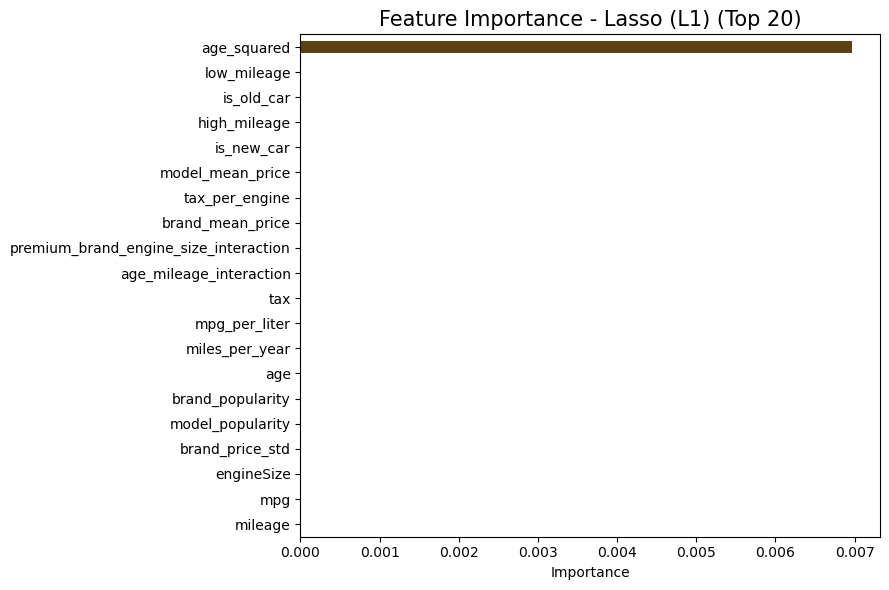


------------------------------------------------------------
MODEL: Lasso (L1)
Threshold: 0.0003
Selected: 1 features
Features: ['age_squared']
------------------------------------------------------------



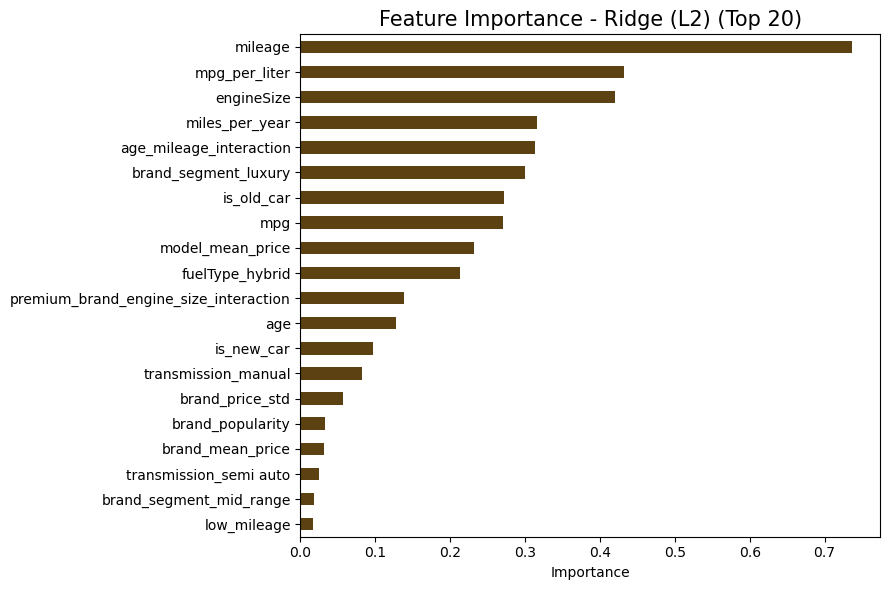


------------------------------------------------------------
MODEL: Ridge (L2)
Threshold: 0.1605
Selected: 10 features
Features: ['mileage', 'mpg', 'engineSize', 'miles_per_year', 'age_mileage_interaction', 'mpg_per_liter', 'model_mean_price', 'is_old_car', 'fuelType_hybrid', 'brand_segment_luxury']
------------------------------------------------------------



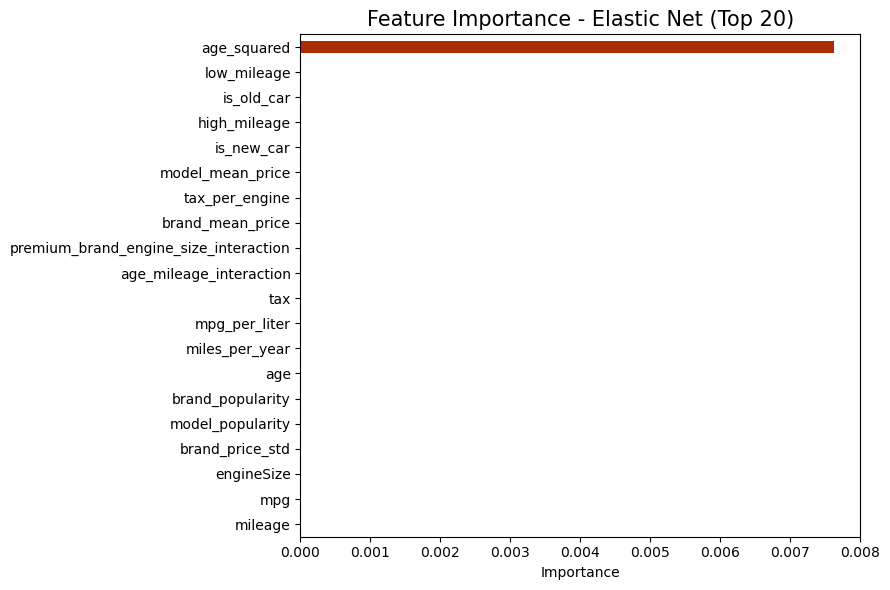


------------------------------------------------------------
MODEL: Elastic Net
Threshold: 0.0003
Selected: 1 features
Features: ['age_squared']
------------------------------------------------------------



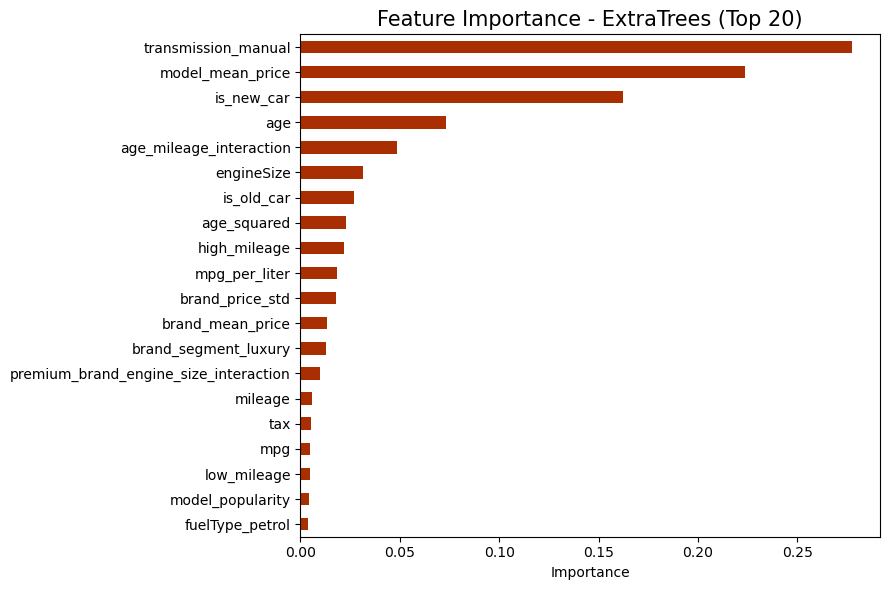


------------------------------------------------------------
MODEL: ExtraTrees
Threshold: 0.0385
Selected: 5 features
Features: ['transmission_manual', 'model_mean_price', 'is_new_car', 'age', 'age_mileage_interaction']
------------------------------------------------------------



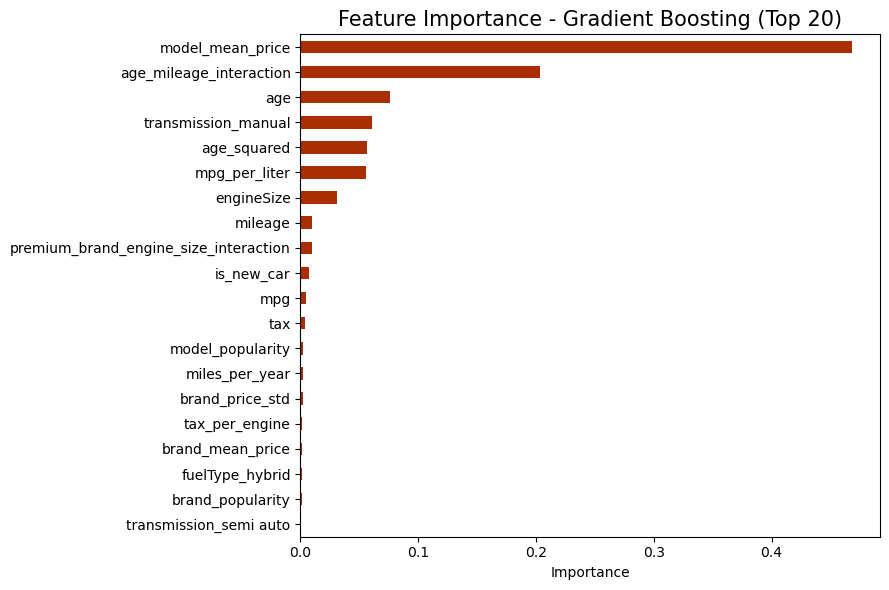


------------------------------------------------------------
MODEL: Gradient Boosting
Threshold: 0.0385
Selected: 6 features
Features: ['model_mean_price', 'age_mileage_interaction', 'age', 'transmission_manual', 'age_squared', 'mpg_per_liter']
------------------------------------------------------------



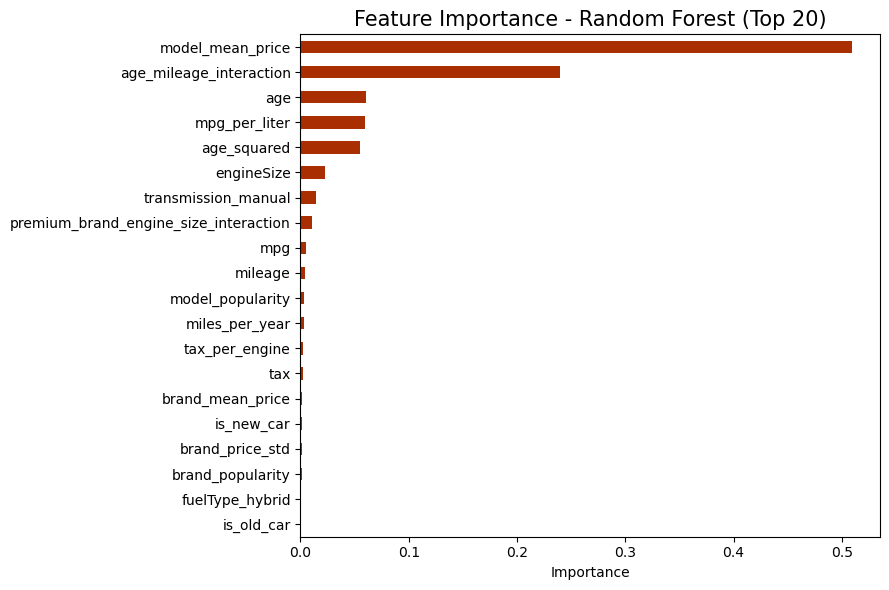


------------------------------------------------------------
MODEL: Random Forest
Threshold: 0.0385
Selected: 5 features
Features: ['model_mean_price', 'age_mileage_interaction', 'age', 'mpg_per_liter', 'age_squared']
------------------------------------------------------------



['model_mean_price',
 'age_mileage_interaction',
 'age',
 'mpg_per_liter',
 'age_squared']

In [30]:
# Plot feature importance
utils.plot_importance_unified(palette, abs(lasso_coefs), "Lasso (L1)", is_tree_model=False)
utils.print_selection_results(abs(lasso_coefs), "Lasso (L1)")

utils.plot_importance_unified(palette, abs(ridge_coefs), "Ridge (L2)", is_tree_model=False) 
utils.print_selection_results(abs(ridge_coefs), "Ridge (L2)")

utils.plot_importance_unified(palette, elasticnet_importance, "Elastic Net", is_tree_model=True)
utils.print_selection_results(elasticnet_importance, "Elastic Net")

utils.plot_importance_unified(palette, et_importance, "ExtraTrees", is_tree_model=True)
utils.print_selection_results(et_importance, "ExtraTrees")

utils.plot_importance_unified(palette, gb_importance, "Gradient Boosting", is_tree_model=True)
utils.print_selection_results(gb_importance, "Gradient Boosting")

utils.plot_importance_unified(palette, rf_importance, "Random Forest", is_tree_model=True)
utils.print_selection_results(rf_importance, "Random Forest")

### 2.6 Optimal Feature Set Selection

We test different numbers of top-ranked features to find the optimal subset that balances model complexity with predictive performance.

In [32]:
# Create ranks for each model (1 = most important)
elasticnet_ranks = pd.Series(range(1, len(elasticnet_importance) + 1), index=elasticnet_importance.index)
et_ranks = pd.Series(range(1, len(et_importance) + 1), index=et_importance.index)
gb_ranks = pd.Series(range(1, len(gb_importance) + 1), index=gb_importance.index)
rf_ranks = pd.Series(range(1, len(rf_importance) + 1), index=rf_importance.index)

# Combine and sort
feature_ranks = (elasticnet_ranks + et_ranks + gb_ranks + rf_ranks).sort_values()

# Final sorted list
ranked_features = feature_ranks.index.tolist()
print(ranked_features)

# Model configurations
model_configs = {
    'ELASTICNET': lambda: ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=37, max_iter=10000),
    'ET': lambda: ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1),
    'GB': lambda: GradientBoostingRegressor(n_estimators=200, max_depth=7, learning_rate=0.06, random_state=37),
    'RF': lambda: RandomForestRegressor(n_estimators=100, max_depth=15, random_state=37, n_jobs=-1),
    'KNN': lambda: KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1),
    'MLP': lambda: MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam',
                                 alpha=0.01, learning_rate='adaptive', max_iter=500,
                                 early_stopping=True, random_state=37)
}

# Initialize results with history for plotting
best_results = {name: {'best_n': None, 'best_mae': float('inf'), 'features': ranked_features,
                       'train_history': [], 'val_history': []} 
                for name in model_configs.keys()}


feature_range = range(1, len(ranked_features) + 1)

print("="*70)
print("FEATURE SELECTION - TESTING OPTIMAL NUMBER")
print("="*70)

for n_features in feature_range:
    features = ranked_features[:n_features]
    
    for model_name, create_model in model_configs.items():
        model = create_model()
        model.fit(X_train_scaled[features], y_train_log)
        
        # Calculate both train and val MAE
        train_mae = mean_absolute_error(y_train_array, np.expm1(model.predict(X_train_scaled[features])))
        val_mae = mean_absolute_error(y_val_array, np.expm1(model.predict(X_val_scaled[features])))
        
        # Store history for plotting
        best_results[model_name]['train_history'].append(train_mae)
        best_results[model_name]['val_history'].append(val_mae)
        
        # Update if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features

    # Show progress
    print(f"n={n_features:2d} | ElasticNet: {best_results['ELASTICNET']['val_history'][-1]:,.0f} | ExtraTrees: {best_results['ET']['val_history'][-1]:,.0f} | GB: {best_results['GB']['val_history'][-1]:,.0f} | RF: {best_results['RF']['val_history'][-1]:,.0f} | KNN: {best_results['KNN']['val_history'][-1]:,.0f} | MLP: {best_results['MLP']['val_history'][-1]:,.0f}")


['age', 'age_squared', 'age_mileage_interaction', 'model_mean_price', 'engineSize', 'mpg_per_liter', 'transmission_manual', 'mileage', 'mpg', 'premium_brand_engine_size_interaction', 'is_new_car', 'brand_price_std', 'model_popularity', 'tax', 'miles_per_year', 'brand_mean_price', 'tax_per_engine', 'brand_popularity', 'is_old_car', 'high_mileage', 'fuelType_hybrid', 'brand_segment_luxury', 'fuelType_petrol', 'low_mileage', 'transmission_semi auto', 'brand_segment_mid_range']
FEATURE SELECTION - TESTING OPTIMAL NUMBER
n= 1 | ElasticNet: 6,810 | ExtraTrees: 5,500 | GB: 5,500 | RF: 5,500 | KNN: 5,759 | MLP: 5,505
n= 2 | ElasticNet: 6,250 | ExtraTrees: 5,500 | GB: 5,500 | RF: 5,500 | KNN: 5,759 | MLP: 5,509
n= 3 | ElasticNet: 6,250 | ExtraTrees: 5,400 | GB: 5,391 | RF: 5,406 | KNN: 5,795 | MLP: 5,461
n= 4 | ElasticNet: 6,250 | ExtraTrees: 2,372 | GB: 2,176 | RF: 2,181 | KNN: 2,229 | MLP: 2,578
n= 5 | ElasticNet: 6,250 | ExtraTrees: 1,976 | GB: 1,661 | RF: 1,627 | KNN: 1,709 | MLP: 2,182
n= 

Based on the feature importance analysis, we focus on selecting features that are consistently ranked as important by our top-performing models (Gradient Boosting and Tandom Forest).

In [33]:
final_features = [#'age',
                   'age_squared', 
                  #'age_mileage_interaction', 
                   'model_mean_price', 
                   'engineSize', 
                   'mpg_per_liter', 
                   'transmission_manual',
                   'mileage', 
                   'mpg',
                   'premium_brand_engine_size_interaction', 
                   #'is_new_car', 
                   'brand_price_std', 
                   'model_popularity', 
                   'tax', 
                   #'miles_per_year', 
                   'brand_mean_price', 
                   'tax_per_engine', 
                   'brand_popularity', 
                   'is_old_car', 
                   #'high_mileage', 
                   'fuelType_hybrid', 
                   #'brand_segment_luxury', 
                   'fuelType_petrol', 
                   #'low_mileage', 
                   #'transmission_semi auto', 
                   'brand_segment_mid_range']

In [34]:
final_features_sorted_rf = (
    rf_importance
    .loc[final_features]
    .sort_values(ascending=False)
    .index
    .tolist()
)

print(final_features_sorted_rf)

feature_range = range(1, len(final_features)+1)

best_results ={}
# Initialize results with history for plotting
best_results = {name: {'best_n': None, 'best_mae': float('inf'), 'features': final_features_sorted_rf,
                       'train_history': [], 'val_history': []} 
                for name in model_configs.keys()}

print("="*70)
print("FEATURE SELECTION - TESTING OPTIMAL NUMBER")
print("="*70)

for n_features in feature_range:
    features = final_features_sorted_rf[:n_features]
    
    for model_name, create_model in model_configs.items():
        model = create_model()
        model.fit(X_train_scaled[features], y_train_log)
        
        # Calculate both train and val MAE
        train_mae = mean_absolute_error(y_train_array, np.expm1(model.predict(X_train_scaled[features])))
        val_mae = mean_absolute_error(y_val_array, np.expm1(model.predict(X_val_scaled[features])))
        
        # Store history for plotting
        best_results[model_name]['train_history'].append(train_mae)
        best_results[model_name]['val_history'].append(val_mae)
        
        # Update if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features

    # Show progress
    print(f"n={n_features:2d} | ElasticNet: {best_results['ELASTICNET']['val_history'][-1]:,.0f} | ExtraTrees: {best_results['ET']['val_history'][-1]:,.0f} | GB: {best_results['GB']['val_history'][-1]:,.0f} | RF: {best_results['RF']['val_history'][-1]:,.0f} | KNN: {best_results['KNN']['val_history'][-1]:,.0f} | MLP: {best_results['MLP']['val_history'][-1]:,.0f}")


['model_mean_price', 'mpg_per_liter', 'age_squared', 'engineSize', 'transmission_manual', 'premium_brand_engine_size_interaction', 'mpg', 'mileage', 'model_popularity', 'tax_per_engine', 'tax', 'brand_mean_price', 'brand_price_std', 'brand_popularity', 'fuelType_hybrid', 'is_old_car', 'brand_segment_mid_range', 'fuelType_petrol']
FEATURE SELECTION - TESTING OPTIMAL NUMBER
n= 1 | ElasticNet: 6,810 | ExtraTrees: 4,356 | GB: 4,351 | RF: 4,351 | KNN: 4,494 | MLP: 4,377
n= 2 | ElasticNet: 6,810 | ExtraTrees: 3,786 | GB: 2,967 | RF: 2,471 | KNN: 2,434 | MLP: 3,848
n= 3 | ElasticNet: 6,250 | ExtraTrees: 2,440 | GB: 1,743 | RF: 1,573 | KNN: 1,595 | MLP: 2,397
n= 4 | ElasticNet: 6,250 | ExtraTrees: 2,274 | GB: 1,660 | RF: 1,525 | KNN: 1,547 | MLP: 2,281
n= 5 | ElasticNet: 6,250 | ExtraTrees: 2,194 | GB: 1,615 | RF: 1,494 | KNN: 1,520 | MLP: 2,171
n= 6 | ElasticNet: 6,250 | ExtraTrees: 2,156 | GB: 1,615 | RF: 1,487 | KNN: 1,518 | MLP: 2,309
n= 7 | ElasticNet: 6,250 | ExtraTrees: 2,123 | GB: 1,59

**Final Feature Selection:** Based on the analysis above, we select the top **14 features** for our models (but removed features thar we saw that were making the main models worst) This number represents the optimal trade-off between model complexity and predictive performance, as validated through cross-validation experiments.


Plotting feature selection results...



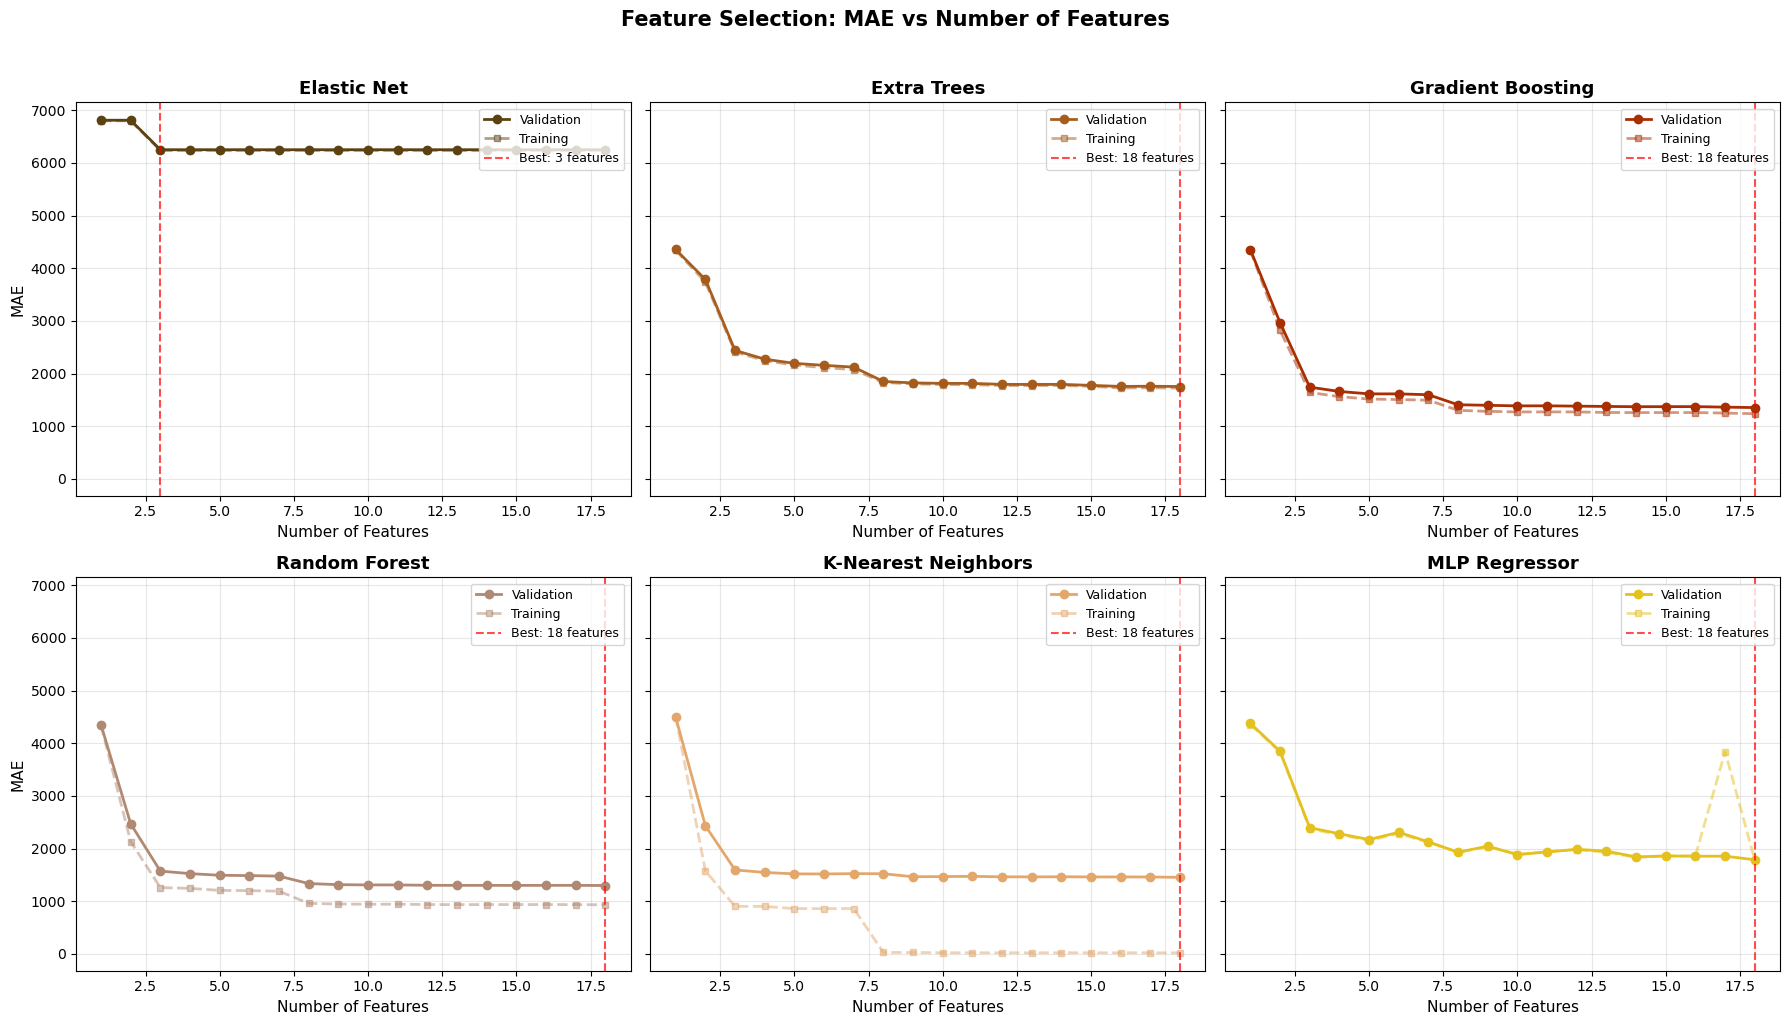

In [35]:
print("\nPlotting feature selection results...\n")

# X-axis: number of features tested
n_values = list(feature_range)

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
axes = axes.flatten()  # Flatten 2D array to 1D for easier iteration

# (key_in_dict, plot_title, palette_color_index)
plots_config = [
    ("ELASTICNET", "Elastic Net", 0),
    ("ET",         "Extra Trees", 2),
    ("GB",         "Gradient Boosting", 1),
    ("RF",         "Random Forest", 3),
    ("KNN",        "K-Nearest Neighbors", 4),
    ("MLP",        "MLP Regressor", 5),
]

for ax, (model_key, title, color_idx) in zip(axes, plots_config):
    train_history = best_results[model_key]["train_history"]
    val_history = best_results[model_key]["val_history"]
    best_n = best_results[model_key]["best_n"]

    # Validation MAE
    ax.plot(
        n_values, val_history,
        marker="o", linewidth=2, markersize=6,
        color=palette[color_idx], label="Validation"
    )

    # Training MAE
    ax.plot(
        n_values, train_history,
        marker="s", linewidth=2, markersize=4,
        color=palette[color_idx], alpha=0.5,
        linestyle="--", label="Training"
    )

    # Best number of features (vertical line)
    ax.axvline(
        best_n, color="red", linestyle="--", alpha=0.7,
        label=f"Best: {int(best_n)} features"
    )

    ax.set_xlabel("Number of Features", fontsize=11)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

# Shared Y label
axes[0].set_ylabel("MAE", fontsize=11)
axes[3].set_ylabel("MAE", fontsize=11)

plt.suptitle("Feature Selection: MAE vs Number of Features", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

In [36]:
print(final_features_sorted_rf)

['model_mean_price', 'mpg_per_liter', 'age_squared', 'engineSize', 'transmission_manual', 'premium_brand_engine_size_interaction', 'mpg', 'mileage', 'model_popularity', 'tax_per_engine', 'tax', 'brand_mean_price', 'brand_price_std', 'brand_popularity', 'fuelType_hybrid', 'is_old_car', 'brand_segment_mid_range', 'fuelType_petrol']


In [43]:
selected_features = ['model_mean_price', 'model_popularity', 
                     'brand_mean_price','premium_brand_engine_size_interaction', 
                     'engineSize', 'mpg', 'mileage', 'tax',
                     'mpg_per_liter', 'age_squared', 'tax_per_engine',
                     'transmission_manual', 'fuelType_hybrid', 'fuelType_petrol']

<a id='3-benchmarking'></a>
<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>

We use a **holdout validation strategy** (80/20 split) to evaluate models. The primary metric is **Mean Absolute Error (MAE)** as it directly represents the average prediction error in pounds.

Estratégia de Holdout: O código usa a divisão Train / Validation (Holdout Validation). Os modelos são treinados em $\mathbf{X_{\text{train\_scaled}}}$ e avaliados em $\mathbf{X_{\text{val\_scaled}}}$.Otimização de Hiperparâmetros (Grid Search Manual):O loop for model_name, config in models_and_grids.items(): executa um Grid Search manual (itera sobre todas as combinações em config['params']).Métrica de Otimização: O critério de otimização é o Val MAE (best_val_mae = float('inf')). O modelo que minimiza o Erro Absoluto Médio no conjunto de Validação é o "melhor".

 A função evaluate_model garante que a previsão (model.predict(X)) é feita na escala $\mathbf{\log(price)}$ e é transformada inversamente (np.expm1) para calcular as métricas na escala original (£). Isto atende ao seu requisito de interpretabilidade.
 Você quer usar $\mathbf{\alpha=0.3}$ (ou similar, e.g., $\mathbf{0.35}$) para refletir a aversão ao risco de sobrestimar o preço.

APAGAR

We benchmark six regression algorithms representing different modeling paradigms:
- **GradientBoosting**: Sequential ensemble learning from residuals
- **RandomForest**: Parallel bagging with bootstrap sampling
- **ExtraTrees**: Randomized splits for reduced variance
- **KNeighbors**: Instance-based learning
- **ElasticNet**: Regularized linear regression (L1 + L2)
- **MLPRegressor**: Neural network with multiple hidden layers

**Evaluation Strategy:** Holdout validation with MAE as primary metric (directly interpretable as average £ error). We monitor train-validation gaps to detect overfitting.

### 3.1 Evaluation Function

We define a standardized evaluation function that computes multiple metrics (MAE, RMSE, Pinball Loss) on both training and validation sets to assess model performance.

### 3.2 Model Selection Strategy & Metrics

**Selection Criterion:** Minimization of Validation MAE (Mean Absolute Error in £)

**Risk Metric:** Validation Pinball Loss (α=0.3) - penalizes underestimation more heavily

**No Free Lunch Theorem:** No single algorithm is universally best for all problems. Therefore, we benchmark multiple model families: Linear Models (Elastic Net), Instance-Based (KNN), Neural Networks (MLP), and Ensemble Methods (Random Forest, Extra Trees, Gradient Boosting).

**Overfitting Detection:** We monitor the ratio Train MAE / Val MAE. A ratio below 0.75 indicates potential overfitting.

In [ ]:
def evaluate_model(model, X_train, y_train_original, X_val, y_val_original):
    # Predict on log scale
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)
    
    # Transform predictions back to original scale (£) in order to calculate interpretable metrics
    y_train_pred = np.expm1(y_train_pred_log)
    y_val_pred = np.expm1(y_val_pred_log)
    
    scores = {
        'Train MAE': mean_absolute_error(y_train_original, y_train_pred),
        'Val MAE': mean_absolute_error(y_val_original, y_val_pred),
        'Train RMSE': root_mean_squared_error(y_train_original, y_train_pred),
        'Val RMSE': root_mean_squared_error(y_val_original, y_val_pred),
        'Train Pinball (α=0.3)': mean_pinball_loss(y_train_original, y_train_pred, alpha=0.3),
        'Val Pinball (α=0.3)': mean_pinball_loss(y_val_original, y_val_pred, alpha=0.3)
    }
    return scores

### 3.3 Model Configuration & Hyperparameter Search

**Why Ensemble Methods?**
Decision Trees alone suffer from high variance and overfitting. Ensemble methods (bagging, boosting) combine multiple weak learners to reduce variance and improve generalization.

**Bagging:** Random Forest (bootstrap + random features), Extra Trees (random splits)
**Boosting:** Gradient Boosting (sequential error correction)

In [45]:
# Model configurations and hyperparameter grids (for a manual Random Search)
models_and_grids = {
    "Elastic Net": {
        "model": ElasticNet(random_state=37, max_iter=2000, tol=0.001),
        "params": {
             'alpha': [0.01, 1, 10], # regularization strength
             'l1_ratio': [0.75, 0.5, 0.25] #focus more on l1_ratio or not
        } 
    },
    "KNeighbors": {
        "model": KNeighborsRegressor(n_jobs=-1, algorithm='ball_tree'), #ball_tree to speed up
        "params": {
            'n_neighbors': [100, 500], # number of neighbors
            'weights': ['distance', 'uniform'], #weight of each neighbor
            'p': [1, 2],  #distance metric:  distância de Manhattan costuma ser mais robusta em espaços de alta dimensão.APAGAR
        }
    },
    "MLPRegressor": {
        "model": MLPRegressor(random_state=37, max_iter=1500, early_stopping=True,tol= 0.001, n_iter_no_change=15),
        "params": {
            "hidden_layer_sizes": [(15,10,7,3), (34, 15, 5)], #following more or less the rule of thumbs we learned in class, this should be ok
            #it a common practice to start with layers that funnel down and also multiple layers (depth) are generally better than a single very wide layer
            "activation": ["relu", "tanh"], #relu: computationally efficient, helps avoid vanishing gradient problem; tanh: zero-centered, which can help in learning
            "alpha": [0.01, 0.001], #to prevent overfitting
            "batch_size": [128, 256], # a little bigger batches to speed up
        
            "solver": ["adam", "sgd"], #adam: efficient for large datasets; lbfgs: can converge faster for smaller datasets
            "learning_rate_init": [0.001, 0.01], #initial learning rate shouldn't be too high to avoid overshooting minima or too low to avoid slow convergence 

            #ADAM specific parameters
            "beta_1": [0.9],
            "beta_2": [0.999],

            #SGD specific parameters
            "learning_rate": ['adaptive'], 
            "momentum": [0.9], 
            "nesterovs_momentum": [True]
        }
    },
    # We know that Decision Trees are usually not strong standalone models (high error, high variance, low stability, and high sensitivity to noise),
    # so we will not use them directly. But this is exactly where ensemble learning methods (bagging, boosting,...) come in.

    #estimator that allows for more randomness like DT APAGAR
    #Random Forest of Random Trees
    "Extra Tree": {
        "model": ExtraTreesRegressor(random_state=37, n_jobs=-1, bootstrap=False), # the split is already random, we don't need bootstrap samples
        "params": {
            'n_estimators': [250, 500], #number of models trained in parallel, we choose high numbers so hopefully it won't overfit and make the result more trustworthy
            'max_depth': [15, 20],
            'min_samples_leaf': [15, 30], # to make sure each leaf has enough samples (not too specific)
            'max_features': ['sqrt', 0.8]
        }
    },
    #Bagging ensemble method that uses bootstrap samples and bootstrap feature subsets based on Decision Trees: Random Forest
    "RandomForest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1, max_samples=0.7),
        "params": {
            'n_estimators': [300, 500],
            'max_features': ['sqrt', 1],
            'max_depth': [15, 20],
            'min_samples_split': [90,120],
            'min_samples_leaf': [15,30],
            #min_impurity_decrease APAGAR: SE FOR NECESSÁRIO + PRUNNUNG
        }
    },
    # Boosting
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=37, loss='absolute_error'),
        "params": {
            'learning_rate': [0.01, 0.05], # low for stability
            'max_depth': [5, 8], # low depth for weak learners
            'n_estimators': [500, 1000], #to compensate for low learning rate
            'subsample': [0.75, 0.85], # subsampling for regularization (anti-overfitting)
            'max_features': ['sqrt', 0.8],
            'min_samples_leaf': [15, 30]
        }
    },
}

### 3.4 Benchmarking Results

The benchmarking loop evaluates each model using a grid search over hyperparameters. We track MAE, RMSE, and Pinball Loss on both training and validation sets, selecting the best configuration per model family based on lowest Validation MAE.

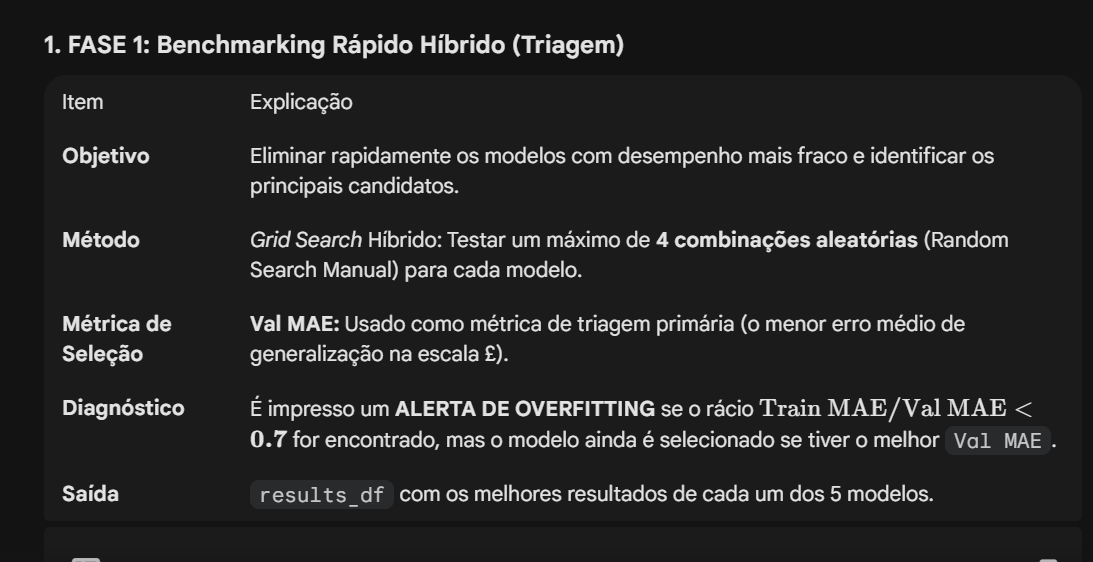

In [46]:
# easier names
y_train_original_for_eval = y_train_array 
y_val_original_for_eval = y_val_array
y_train_log_for_fit = y_train_log

########################################################
# 1: hybrid benchmarking (MANUAL RANDOM SEARCH)        #
########################################################
results_list = []

print("PHASE 1: Initial benchmarking with Manual Random Search")
print("="*80)

# Loop through each model and its hyperparameter grid
for model_name, config in models_and_grids.items():
    print(f"\n---> Optimizing {model_name}")
    
    X_tr = X_train_scaled[selected_features]
    X_vl = X_val_scaled[selected_features]
    
    # Generate all possible parameter combinations
    param_combinations = list(product(*config['params'].values()))
    param_keys = list(config['params'].keys())

    # Select at most 4 random combinations to test
    if len(param_combinations) > 4:
        tested_params = random.sample(param_combinations, 4)
        print(f"Testing 4 random combinations out of {len(param_combinations)}:\n")
    else:
        tested_params = param_combinations
        print(f"Testing all {len(param_combinations)} combinations:\n")

    # track the best model and its metrics
    best_val_mae = float('inf')
    best_result = None

    # Loop through the parameters
    for values in tested_params:
        params = dict(zip(param_keys, values))
        model = clone(config['model'])
        model.set_params(**params)
        model.fit(X_tr, y_train_log_for_fit) # fit on log-price
        
        scores = evaluate_model(model, X_tr, y_train_original_for_eval, X_vl, y_val_original_for_eval) #gets scores in original scale (£)

        # the model with the lowest Val MAE is considered the best model for that family algorithm
        if scores['Val MAE'] < best_val_mae:
            best_val_mae = scores['Val MAE']
            best_result = {
                'Model': model_name,
                'Best Params': str(params),
                **scores,
                }
            
            # Check for overfitting
            overfit_ratio = scores['Train MAE'] / scores['Val MAE']
            if overfit_ratio < 0.75:
                print(f"    !!! OVERFITTING: Train MAE/Val MAE Ratio < 0.75: {overfit_ratio:.2f} !!!")
            print(f"  New best: {params} | VAL MAE:{scores['Val MAE']:,.2f} | Pinball(0.3):{scores['Val Pinball (α=0.3)']:.2f} | Val RMSE:{scores['Val RMSE']:.2f} ")

    # only adds the best VAL MAE result of each model to the phase 1 results list
    if best_result:
        results_list.append(best_result)

   
# Final results phase 1 DataFrame
results_df = pd.DataFrame(results_list).sort_values('Val MAE')
print("\n" + "="*80)
print("Final benchmarking results per model (phase 1):")
display(results_df[['Model','Train MAE', 'Val MAE','Train Pinball (α=0.3)', 'Val Pinball (α=0.3)','Train RMSE', 'Val RMSE', 'Best Params']])

# Get the best parameters from phase 1 for use in phase 2
best_params_phase1 = {}
for model_name in results_df['Model'].unique():
    params_str = results_df[results_df['Model'] == model_name]['Best Params'].values[0]
    best_params_phase1[model_name] = eval(params_str)

print("\nOptimized Parameters from Phase 1:")
for name, params in best_params_phase1.items():
    print(f" - {name}: {params}")


PHASE 1: Initial benchmarking with Manual Random Search

---> Optimizing Elastic Net
Testing 4 random combinations out of 9:

  New best: {'alpha': 0.01, 'l1_ratio': 0.5} | VAL MAE:2,323.87 | Pinball(0.3):1082.16 | Val RMSE:3972.12 
  New best: {'alpha': 0.01, 'l1_ratio': 0.25} | VAL MAE:2,302.58 | Pinball(0.3):1077.16 | Val RMSE:3925.56 

---> Optimizing KNeighbors
Testing 4 random combinations out of 8:

  New best: {'n_neighbors': 500, 'weights': 'uniform', 'p': 2} | VAL MAE:2,358.15 | Pinball(0.3):1028.45 | Val RMSE:4204.29 
    !!! OVERFITTING: Train MAE/Val MAE Ratio < 0.75: 0.01 !!!
  New best: {'n_neighbors': 500, 'weights': 'distance', 'p': 1} | VAL MAE:1,875.79 | Pinball(0.3):835.99 | Val RMSE:3571.63 
    !!! OVERFITTING: Train MAE/Val MAE Ratio < 0.75: 0.01 !!!
  New best: {'n_neighbors': 100, 'weights': 'distance', 'p': 1} | VAL MAE:1,578.28 | Pinball(0.3):735.59 | Val RMSE:2974.85 

---> Optimizing MLPRegressor
Testing 4 random combinations out of 64:

  New best: {'hidde

,Model,Train MAE,Val MAE,Train Pinball (α=0.3),Val Pinball (α=0.3),Train RMSE,Val RMSE,Best Params
5,GradientBoosting,1170.874921,1309.125574,553.328341,619.084814,2211.675248,2312.903450,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est..."
3,Extra Tree,1431.959816,1508.462390,662.668292,701.007640,2668.987074,2724.989953,"{'n_estimators': 500, 'max_depth': 20, 'min_sa..."
1,KNeighbors,20.976849,1578.280319,10.313208,735.589108,206.370471,2974.851685,"{'n_neighbors': 100, 'weights': 'distance', 'p..."
4,RandomForest,1550.302289,1596.199821,705.105003,727.317915,2937.290013,2986.127240,"{'n_estimators': 300, 'max_features': 'sqrt', ..."
2,MLPRegressor,1701.751603,1727.351669,799.214827,813.299740,3051.135938,3076.119484,"{'hidden_layer_sizes': (34, 15, 5), 'activatio..."
0,Elastic Net,2328.949119,2302.584894,1086.462084,1077.155326,4036.036147,3925.558906,"{'alpha': 0.01, 'l1_ratio': 0.25}"



Optimized Parameters from Phase 1:
 - GradientBoosting: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.85, 'max_features': 0.8, 'min_samples_leaf': 30}
 - Extra Tree: {'n_estimators': 500, 'max_depth': 20, 'min_samples_leaf': 15, 'max_features': 0.8}
 - KNeighbors: {'n_neighbors': 100, 'weights': 'distance', 'p': 1}
 - RandomForest: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 90, 'min_samples_leaf': 15}
 - MLPRegressor: {'hidden_layer_sizes': (34, 15, 5), 'activation': 'tanh', 'alpha': 0.001, 'batch_size': 128, 'solver': 'adam', 'learning_rate_init': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'learning_rate': 'adaptive', 'momentum': 0.9, 'nesterovs_momentum': True}
 - Elastic Net: {'alpha': 0.01, 'l1_ratio': 0.25}


### 3.5 Model Selection Results

Based on sequential filtering (overfitting ratio, MAE, RMSE, Pinball), we select the top-performing models for further optimization.

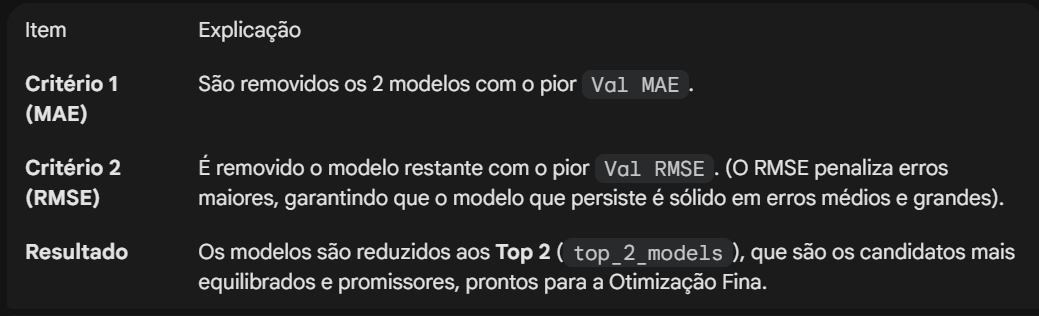

In [47]:
df_selection = results_df.copy()

# 0. Severe Overfitting Filter (Ratio >= 0.5)
initial_count = len(df_selection)
df_selection['Ratio_Phase1'] = df_selection['Train MAE'] / df_selection['Val MAE']
df_selection = df_selection[df_selection['Ratio_Phase1'] >= 0.5]

if len(df_selection) < initial_count:
    discarded = results_df[~results_df.index.isin(df_selection.index)]['Model'].tolist()
    print(f"\nStep 0: Discarded {initial_count - len(df_selection)} models due to severe Overfitting (Ratio < 0.5): {discarded}")

#      Making we have 2 models to proceed
# 1. Discard by MAE: it only discards 2 if there are at least 5 models
if len(df_selection) > 4:
    df_selection = df_selection.sort_values('Val MAE', ascending=True).head(len(df_selection) - 2)
    print(f"Step 1: Discarded 2 models (worst MAE). Remaining: {df_selection['Model'].tolist()}")
elif len(df_selection) == 4: # If there are exactly 4, just discard 1
    df_selection = df_selection.sort_values('Val MAE', ascending=True).head(3)
    print(f"Step 1: Discarded 1 model (worst MAE). Remaining: {df_selection['Model'].tolist()}")

# 2. Discard by RMSE: it only discards 1 if there are more than 2 models
if len(df_selection) > 2:
    df_selection = df_selection.sort_values('Val RMSE', ascending=True).head(len(df_selection) - 1)
    print(f"Step 2: Discarded 1 model (worst RMSE). Remaining: {df_selection['Model'].tolist()}")

# 3. Final Selection by Pinball: if still more than 2
if len(df_selection) > 2:
    df_selection = df_selection.sort_values('Val Pinball (α=0.3)', ascending=True).head(2)
    print(f"Step 3: Selected best 2 by Pinball. Remaining: {df_selection['Model'].tolist()}")
else:
    # Se já só tiveres 2, apenas garante que estão ordenados
    df_selection = df_selection.sort_values('Val Pinball (α=0.3)', ascending=True)

# Top 2 models selected
top_2_models = df_selection['Model'].tolist()
print(f"The {len(top_2_models)} models selected for phase 2 (Refinement/Stacking) are: {top_2_models}")



Step 0: Discarded 1 models due to severe Overfitting (Ratio < 0.5): ['KNeighbors']
Step 1: Discarded 2 models (worst MAE). Remaining: ['GradientBoosting', 'Extra Tree', 'RandomForest']
Step 2: Discarded 1 model (worst RMSE). Remaining: ['GradientBoosting', 'Extra Tree']
The 2 models selected for phase 2 (Refinement/Stacking) are: ['GradientBoosting', 'Extra Tree']


In [48]:
#######################################################################
# 2: more refined optimization focusing on top 2 and anti-overfitting #
#######################################################################
# new grids for the winners of phase 1
models_and_grids_phase2 = {}

if "GradientBoosting" in top_2_models:
    models_and_grids_phase2["GradientBoosting"] = {
        "model": GradientBoostingRegressor(random_state=37, loss='absolute_error'),
        "params": {
            # Refinamento em torno dos 0.05 e depth 8 da Fase 1
            'learning_rate': [0.03, 0.05, 0.07], 
            'max_depth': [7, 8, 9],
            'n_estimators': [500, 800, 1000],
            'subsample': [0.8, 0.85, 0.9],
            'min_samples_leaf': [25, 30, 35]
        }
    }

if "Extra Tree" in top_2_models:
    models_and_grids_phase2["Extra Tree"] = {
        "model": ExtraTreesRegressor(random_state=37, n_jobs=-1, bootstrap=False),
        "params": {
            # Refinamento em torno de 500 estimators e depth 20
            'n_estimators': [500, 600, 700],
            'max_depth': [18, 20, 22, 25],
            'min_samples_leaf': [10, 15, 20],
            'max_features': [0.7, 0.8, 0.9]
        }
    }

# --- STEP 2.2: LOOP DE OTIMIZAÇÃO (MANTIDO E PROTEGIDO) ---
results_list_phase2 = []
print("\nPHASE 2: More Fine-Tuning & Exploration (Top Models: GB & Extra Trees)")
print("="*80)

for model_name, config in models_and_grids_phase2.items():
    print(f"\n---> Refinement: {model_name}")
    
    X_tr = X_train_scaled[selected_features]
    X_vl = X_val_scaled[selected_features]

    # Initialize with the Phase 1 best model
    best_params_f1 = best_params_phase1[model_name]
    model_f1 = clone(config['model']).set_params(**best_params_f1)
    model_f1.fit(X_tr, y_train_log_for_fit)
    
    # Scores for comparison
    best_scores_p2 = evaluate_model(model_f1, X_tr, y_train_original_for_eval, X_vl, y_val_original_for_eval)
    best_val_mae_p2 = best_scores_p2['Val MAE']
    curr_best_rmse = best_scores_p2['Val RMSE']
    curr_best_pinball = best_scores_p2['Val Pinball (α=0.3)']
    
    best_result_phase2 = {
        'Model': model_name,
        'Best Params': str(best_params_f1),
        'MAE_Ratio': best_scores_p2['Train MAE'] / best_scores_p2['Val MAE'],
        'Source': 'Phase 1 Winner',
        **best_scores_p2,
    }
    
    print(f"  Base (Phase 1): {best_params_f1} | MAE: {best_val_mae_p2:,.2f}")

    # Try 10 new random parameter combinations
    param_combinations = list(product(*config['params'].values()))
    param_keys = list(config['params'].keys())
    tested_params = random.sample(param_combinations, min(len(param_combinations), 10))
    
    for values in tested_params:
        params = dict(zip(param_keys, values))
        if params == best_params_f1: continue
            
        model = clone(config['model']).set_params(**params)
        model.fit(X_tr, y_train_log_for_fit)
        scores = evaluate_model(model, X_tr, y_train_original_for_eval, X_vl, y_val_original_for_eval)
        
        ovf_ratio = scores['Train MAE'] / scores['Val MAE']
        
        # I. Anti-Overfitting Filter (Ratio > 0.75)
        if ovf_ratio < 0.75:
            print(f"   [REJECTED - OVF] Ratio: {ovf_ratio:.2f} | Params: {params}")
            continue
            
        # II. Stability check (RMSE < 5% degradation, Pinball < 10%)
        rmse_limit = curr_best_rmse * 1.05
        pinball_limit = curr_best_pinball * 1.10
        
        if scores['Val RMSE'] > rmse_limit or scores['Val Pinball (α=0.3)'] > pinball_limit:
            print(f"   [REJECTED - STABILITY] MAE might be better, but RMSE/Pinball degraded too much. Params: {params}")
            continue

        # III. Update if MAE is better
        if scores['Val MAE'] < best_val_mae_p2:
            best_val_mae_p2 = scores['Val MAE']
            curr_best_rmse = scores['Val RMSE']
            curr_best_pinball = scores['Val Pinball (α=0.3)']
            
            best_result_phase2 = {
                'Model': model_name,
                'Best Params': str(params),
                'MAE_Ratio': ovf_ratio,
                'Source': 'Phase 2 Improvement',
                **scores,
            }
            # new: Print detalhado solicitado
            print(f" New Improvement Found for {model_name}:")
            print(f" Train MAE: {scores['Train MAE']:,.2f} | Val MAE: {scores['Val MAE']:,.2f}")
            print(f" Train Pinball: {scores['Train Pinball (α=0.3)']:,.2f} | Val Pinball: {scores['Val Pinball (α=0.3)']:,.2f}")
            print(f" Train RMSE: {scores['Train RMSE']:,.2f} | Val RMSE: {scores['Val RMSE']:,.2f}")
            print(f" Overfitting Ratio: {ovf_ratio:.2f}\n")

    results_list_phase2.append(best_result_phase2)

# Final Results Visualization
results_df_phase2 = pd.DataFrame(results_list_phase2).sort_values('Val MAE')
display(results_df_phase2[['Model','Train MAE', 'Val MAE','MAE_Ratio','Train Pinball (α=0.3)', 'Val Pinball (α=0.3)','Train RMSE', 'Val RMSE', 'Best Params']])



PHASE 2: More Fine-Tuning & Exploration (Top Models: GB & Extra Trees)

---> Refinement: GradientBoosting
  Base (Phase 1): {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.85, 'max_features': 0.8, 'min_samples_leaf': 30} | MAE: 1,309.13
 New Improvement Found for GradientBoosting:
 Train MAE: 1,078.53 | Val MAE: 1,270.62
 Train Pinball: 511.01 | Val Pinball: 602.68
 Train RMSE: 2,051.82 | Val RMSE: 2,231.86
 Overfitting Ratio: 0.85

   [REJECTED - STABILITY] MAE might be better, but RMSE/Pinball degraded too much. Params: {'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 800, 'subsample': 0.9, 'min_samples_leaf': 30}
   [REJECTED - STABILITY] MAE might be better, but RMSE/Pinball degraded too much. Params: {'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8, 'min_samples_leaf': 35}
   [REJECTED - STABILITY] MAE might be better, but RMSE/Pinball degraded too much. Params: {'learning_rate': 0.03, 'max_depth': 7, 'n_estimators':

,Model,Train MAE,Val MAE,MAE_Ratio,Train Pinball (α=0.3),Val Pinball (α=0.3),Train RMSE,Val RMSE,Best Params
0,GradientBoosting,1078.532941,1270.620871,0.848824,511.014940,602.682437,2051.823565,2231.864640,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est..."
1,Extra Tree,1310.773196,1430.519413,0.916292,611.592695,670.735605,2416.000602,2542.727737,"{'n_estimators': 500, 'max_depth': 22, 'min_sa..."


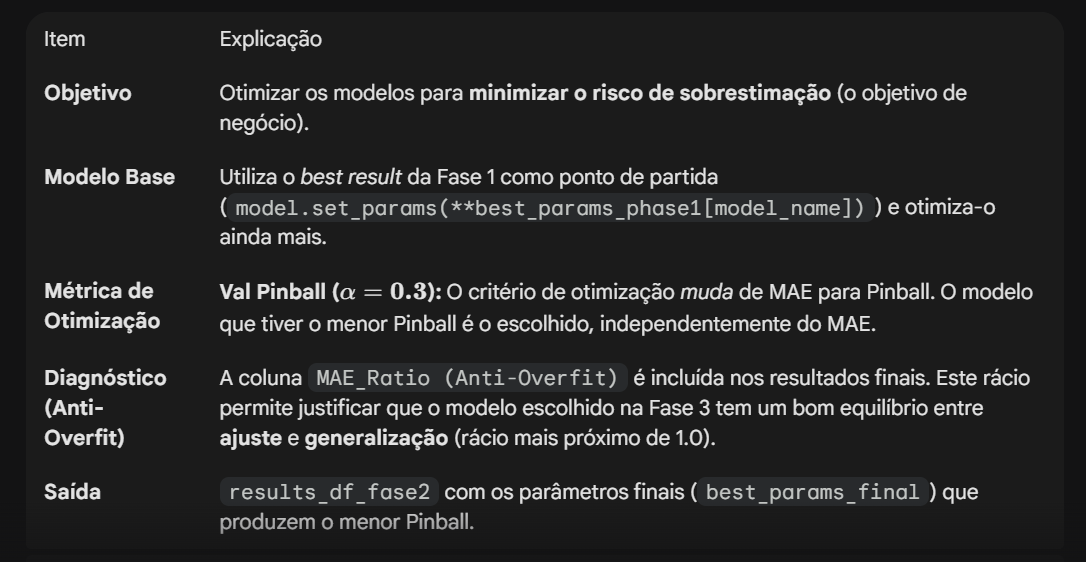

<a id='4-optimization'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>4 | Model Optimization</b></span>
    </h1>
</div>

Ensemble methods combine multiple models to improve prediction accuracy and robustness. We implement two approaches:

1. **Weighted Average Ensemble**: Optimize linear combination weights via SLSQP to minimize validation MAE
2. **Stacking Ensemble**: Train Ridge meta-learner on cross-validated base model predictions

Both leverage model diversity to reduce prediction variance while maintaining low bias. Log transformation of the target further reduces outlier influence.

### 4.1 Stacking Ensemble

**Stacking** combines predictions from multiple base models using a meta-learner (Ridge) that learns optimal weights. We use cv=5 to generate out-of-fold predictions, preventing data leakage during meta-learner training.

In [49]:
# 1. Preparar os estimadores base com os parâmetros da FASE 2
final_estimators = []
for result in results_list_phase2:
    name = result['Model']
    # eval converte a string de parâmetros de volta para dicionário
    params = eval(result['Best Params']) 
    
    # Criar a instância do modelo
    model_instance = clone(models_and_grids[name]['model'])
    
    # Aplicar os parâmetros da Fase 1 (base) + Fase 2 (refinamento)
    if name in best_params_phase1:
        model_instance.set_params(**best_params_phase1[name])
    model_instance.set_params(**params)
    
    final_estimators.append((name.lower().replace(" ", "_"), model_instance))

# 2. Criar o Stacking Regressor
# O Ridge(alpha=10) é o "juiz" que decide quanto peso dar a cada modelo
stacking_model = StackingRegressor(
    estimators=final_estimators,
    final_estimator=Ridge(alpha=10.0), 
    cv=5, 
    n_jobs=-1
)

# 3. Treinar no Full Dataset
print(f"\nTraining Final Stacking Ensemble with: {[e[0] for e in final_estimators]}")
stacking_model.fit(X_train_full_scaled[selected_features], y_train_full_log)

# 4. Avaliação Final (sempre no conjunto de validação para o relatório)
y_val_final_pred = np.expm1(stacking_model.predict(X_val_scaled[selected_features]))
final_mae = mean_absolute_error(y_val_array, y_val_final_pred)

print(f"- FINAL STACKING VAL MAE: {final_mae:,.2f}")
#PRINT FINAL STACKING TRAIN MAE
y_train_final_pred = np.expm1(stacking_model.predict(X_train_full_scaled[selected_features]))
final_train_mae = mean_absolute_error(y_train_full_array, y_train_final_pred)
print(f"- FINAL STACKING TRAIN MAE: {final_train_mae:,.2f}")


Training Final Stacking Ensemble with: ['gradientboosting', 'extra_tree']
- FINAL STACKING VAL MAE: 1,094.77
- FINAL STACKING TRAIN MAE: 1,094.94


### 4.2 Weighted Average Ensemble (All Models)

As an alternative to stacking, we implement a **weighted average ensemble** that combines predictions from all available models:
- **Phase 1 models:** ElasticNet, KNeighbors, RandomForest, MLPRegressor
- **Phase 2 refined models:** GradientBoosting, ExtraTrees (with optimized hyperparameters)

The optimal weights are learned by minimizing validation MAE using SLSQP optimization. This approach allows each model to contribute according to its predictive strength.

In [53]:
gb_model = GradientBoostingRegressor(**best_result_phase2.get('GradientBoosting', {}), random_state=37)
gb_model.fit(X_train_scaled[selected_features], y_train_log)
print(f"  - GradientBoosting trained")

et_model = ExtraTreesRegressor(**best_result_phase2.get('Extra Tree', {}), random_state=37, n_jobs=-1)
et_model.fit(X_train_scaled[selected_features], y_train_log)
print(f"  - ExtraTrees trained")

rf_model = RandomForestRegressor(**best_params_phase1.get('RandomForest', {}), random_state=37, n_jobs=-1)
rf_model.fit(X_train_scaled[selected_features], y_train_log)
print(f"  - RandomForest trained")

knn_model = KNeighborsRegressor(**best_params_phase1.get('KNeighbors', {}), n_jobs=-1)
knn_model.fit(X_train_scaled[selected_features], y_train_log)
print(f"  - KNeighbors trained")

en_model = ElasticNet(**best_params_phase1.get('Elastic Net', {}), random_state=37)
en_model.fit(X_train_scaled[selected_features], y_train_log)
print(f"  - ElasticNet trained")

mlp_model = MLPRegressor(**best_params_phase1['MLPRegressor'], random_state=37)
mlp_model.fit(X_train_scaled[selected_features], y_train_log)
print(f"  -  MLPRegressor trained")

print("\nComputing predictions...")

# Get predictions from all models (log scale)
gb_train_pred = gb_model.predict(X_train_scaled[selected_features])
et_train_pred = et_model.predict(X_train_scaled[selected_features])
rf_train_pred = rf_model.predict(X_train_scaled[selected_features])
knn_train_pred = knn_model.predict(X_train_scaled[selected_features])
en_train_pred = en_model.predict(X_train_scaled[selected_features])
mlp_train_pred = mlp_model.predict(X_train_scaled[selected_features])

gb_val_pred = gb_model.predict(X_val_scaled[selected_features])
et_val_pred = et_model.predict(X_val_scaled[selected_features])
rf_val_pred = rf_model.predict(X_val_scaled[selected_features])
knn_val_pred = knn_model.predict(X_val_scaled[selected_features])
en_val_pred = en_model.predict(X_val_scaled[selected_features])
mlp_val_pred = mlp_model.predict(X_val_scaled[selected_features])

# Evaluate individual models
print("Individual Model Performance")

models_info = [
    ('GradientBoosting (P2)', gb_val_pred, gb_train_pred),
    ('ExtraTrees (P2)', et_val_pred, et_train_pred),
    ('RandomForest (P1)', rf_val_pred, rf_train_pred),
    ('KNeighbors (P1)', knn_val_pred, knn_train_pred),
    ('ElasticNet (P1)', en_val_pred, en_train_pred),
    ('MLPRegressor (P1)', mlp_val_pred, mlp_train_pred)
]

print(f"\n{'Model':<25} | {'Train MAE':>12} | {'Val MAE':>12} | {'Ratio':>8}")
print("-"*65)

for name, val_pred, train_pred in models_info:
    val_mae = mean_absolute_error(y_val_array, np.expm1(val_pred))
    train_mae = mean_absolute_error(y_train_array, np.expm1(train_pred))
    ratio = train_mae / val_mae
    print(f"{name:<25} | {train_mae:>10,.2f} | {val_mae:>10,.2f} | {ratio:>8.3f}")

  - GradientBoosting trained
  - ExtraTrees trained
  - RandomForest trained
  - KNeighbors trained
  - ElasticNet trained
  -  MLPRegressor trained

Computing predictions...
Individual Model Performance

Model                     |    Train MAE |      Val MAE |    Ratio
-----------------------------------------------------------------
GradientBoosting (P2)     |   1,766.41 |   1,776.25 |    0.994
ExtraTrees (P2)           |      20.98 |   1,322.00 |    0.016
RandomForest (P1)         |   1,502.09 |   1,561.28 |    0.962
KNeighbors (P1)           |      20.98 |   1,578.28 |    0.013
ElasticNet (P1)           |   2,328.86 |   2,302.49 |    1.011
MLPRegressor (P1)         |   1,734.80 |   1,751.56 |    0.990


In [ ]:
def ensemble_mae_objective(weights, predictions_val, y_val):
    """Calculate validation MAE for weighted ensemble"""
    weights = np.array(weights) / np.sum(weights)
    val_pred_log = sum(w * p for w, p in zip(weights, predictions_val))
    return mean_absolute_error(y_val, np.expm1(val_pred_log))

# Prepare predictions lists
train_preds = [gb_train_pred, et_train_pred, rf_train_pred, knn_train_pred, en_train_pred, mlp_train_pred]
val_preds = [gb_val_pred, et_val_pred, rf_val_pred, knn_val_pred, en_val_pred, mlp_val_pred]
model_names = ['GradientBoosting', 'Extra Tree', 'RandomForest', 'KNeighbors', 'ElasticNet', 'MLPRegressor']
n_models = 6


# Initial weights (equal)
initial_weights = [1.0/n_models] * n_models

# Optimize weights
print("Optimizing ensemble weights...", end=" ", flush=True)
result = minimize(
    ensemble_mae_objective,
    initial_weights,
    args=(val_preds, y_val_array),
    method='SLSQP',
    bounds=[(0.0, 1.0)] * n_models,
    constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
)

optimal_weights = result.x / np.sum(result.x)

# Store weights in a dictionary for easy access
weights_dict = {name: w for name, w in zip(model_names, optimal_weights)}

# Calculate ensemble predictions
ensemble_val_pred_log = sum(w * p for w, p in zip(optimal_weights, val_preds))
ensemble_train_pred_log = sum(w * p for w, p in zip(optimal_weights, train_preds))

ensemble_val_pred = np.expm1(ensemble_val_pred_log)
ensemble_train_pred = np.expm1(ensemble_train_pred_log)

ensemble_val_mae = mean_absolute_error(y_val_array, ensemble_val_pred)
ensemble_train_mae = mean_absolute_error(y_train_array, ensemble_train_pred)


print(f"\nOptimal Weights ({n_models} models):")
for name, weight in zip(model_names, optimal_weights):
    print(f"  {name:20s}: {weight:.4f}")

print(f"\n{'Metric':<25} | {'Train':>15} | {'Validation':>15}")
print("-"*60)
print(f"{'Weighted Ensemble MAE':<25} | {ensemble_train_mae:>13,.2f} | {ensemble_val_mae:>13,.2f}")
print(f"{'Overfitting Ratio':<25} | {ensemble_train_mae/ensemble_val_mae:>15.3f} |")



Optimizing ensemble weights... 
Optimal Weights (6 models):
  GradientBoosting    : 0.0070
  Extra Tree          : 0.7995
  RandomForest        : 0.1365
  KNeighbors          : 0.0000
  ElasticNet          : 0.0000
  MLPRegressor        : 0.0569

Metric                    |           Train |      Validation
------------------------------------------------------------
Weighted Ensemble MAE     |        326.80 |      1,302.12
Overfitting Ratio         |           0.251 |


In [57]:
# Predict on FULL TRAIN (log-space)
gb_trainfull_pred  = gb_model.predict(X_train_full_scaled[selected_features])
et_trainfull_pred  = et_model.predict(X_train_full_scaled[selected_features])
rf_trainfull_pred  = rf_model.predict(X_train_full_scaled[selected_features])
knn_trainfull_pred = knn_model.predict(X_train_full_scaled[selected_features])
en_trainfull_pred  = en_model.predict(X_train_full_scaled[selected_features])
mlp_trainfull_pred = mlp_model.predict(X_train_full_scaled[selected_features])

# Predict on VALIDATION (log-space) using the same full-trained models
gb_val_pred_full  = gb_model.predict(X_val_scaled[selected_features])
et_val_pred_full  = et_model.predict(X_val_scaled[selected_features])
rf_val_pred_full  = rf_model.predict(X_val_scaled[selected_features])
knn_val_pred_full = knn_model.predict(X_val_scaled[selected_features])
en_val_pred_full  = en_model.predict(X_val_scaled[selected_features])
mlp_val_pred_full = mlp_model.predict(X_val_scaled[selected_features])


In [60]:
# 3. "Treinar" no Full Dataset (no weighted ensemble não há fit aqui)
print(f"\nTraining Final Weighted Ensemble with: {model_names}")

# 4. Avaliação Final (sempre no conjunto de validação para o relatório)
# IMPORTANT: these predictions must be computed using models fitted on the full training set
val_preds_full = [
    gb_val_pred_full, et_val_pred_full, rf_val_pred_full,
    knn_val_pred_full, en_val_pred_full, mlp_val_pred_full
]

train_full_preds = [
    gb_trainfull_pred, et_trainfull_pred, rf_trainfull_pred,
    knn_trainfull_pred, en_trainfull_pred, mlp_trainfull_pred
]

# Weighted sum in log-space
ensemble_val_pred_log = sum(w * p for w, p in zip(optimal_weights, val_preds_full))
ensemble_train_full_pred_log = sum(w * p for w, p in zip(optimal_weights, train_full_preds))

# Back to original scale
y_val_ensemble_pred = np.expm1(ensemble_val_pred_log)
y_train_full_ensemble_pred = np.expm1(ensemble_train_full_pred_log)

# Metrics
final_val_mae = mean_absolute_error(y_val_array, y_val_ensemble_pred)
final_train_mae = mean_absolute_error(y_train_full_array, y_train_full_ensemble_pred)

print(f"- FINAL WEIGHTED ENSEMBLE VAL MAE: {final_val_mae:,.2f}")
print(f"- FINAL WEIGHTED ENSEMBLE TRAIN MAE: {final_train_mae:,.2f}")



Training Final Weighted Ensemble with: ['GradientBoosting', 'Extra Tree', 'RandomForest', 'KNeighbors', 'ElasticNet', 'MLPRegressor']
- FINAL WEIGHTED ENSEMBLE VAL MAE: 1,302.12
- FINAL WEIGHTED ENSEMBLE TRAIN MAE: 521.87


### FINAL COMPARISON: Stacking vs Weighted Ensemble

In [62]:
# Stacking predictions
stacking_val_pred = np.expm1(stacking_model.predict(X_val_scaled[selected_features]))
stacking_val_mae = mean_absolute_error(y_val_array, stacking_val_pred)
stacking_train_pred = np.expm1(stacking_model.predict(X_train_scaled[selected_features]))
stacking_train_mae = mean_absolute_error(y_train_array, stacking_train_pred)

print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)

print(f"\n{'Model':<30} | {'Train MAE':>12} | {'Val MAE':>12} | {'Ratio':>8}")
print("-"*70)
print(f"{'Weighted Ensemble (' + str(n_models) + ' models)':<30} | {final_train_mae:>10,.2f} | {final_val_mae:>10,.2f} | {final_train_mae/final_val_mae:>8.3f}")
print(f"{'Stacking (2 + Ridge)':<30} | {stacking_train_mae:>10,.2f} | {stacking_val_mae:>10,.2f} | {stacking_train_mae/stacking_val_mae:>8.3f}")

# Determine best
diff = abs(ensemble_val_mae - stacking_val_mae)
if ensemble_val_mae < stacking_val_mae:
    print(f"\nWeighted Ensemble wins by {diff:,.2f}")
    best_approach = "weighted"
else:
    print(f"\nStacking wins by {diff:,.2f}")
    best_approach = "stacking"


FINAL MODEL COMPARISON

Model                          |    Train MAE |      Val MAE |    Ratio
----------------------------------------------------------------------
Weighted Ensemble (6 models)   |     521.87 |   1,302.12 |    0.401
Stacking (2 + Ridge)           |   1,094.98 |   1,094.77 |    1.000

Stacking wins by 207.34


### 4.3 Model Interpretability with LIME

**LIME** provides local explanations for individual predictions, showing which features drove the model's decision for a specific car.

In [65]:
# configurate LIME explainer: we use the full training data
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_full_scaled[selected_features].values,
    feature_names=selected_features,
    mode='regression',
    verbose=True,
    random_state=37
)

#Choose a specific row from the test set to explain
row_idx = 0 
observation = X_test_scaled[selected_features].iloc[row_idx]

def predict_fn_with_names(x_array):
    #converts the numpy array back to DataFrame with original names
    x_df = pd.DataFrame(x_array, columns=selected_features)
    #predict original price from log predictions
    return np.expm1(stacking_model.predict(x_df))

print(f"Generating explanation for the car (carID): {X_test_scaled.index[row_idx]}...")
exp = explainer.explain_instance(
    data_row=observation.values, 
    predict_fn=predict_fn_with_names,
    num_features=10
)

display(HTML(exp.as_html()))

price_predicted = predict_fn_with_names(observation.values.reshape(1, -1))[0]
print(f"\nPredicted Price by Stacking: £{price_predicted:,.2f}")

print("\nTop 5 Features Influencing this prediction:")
for feature, weight in exp.as_list()[:5]:
    direction = "Increases price" if weight > 0 else "Decreases price"
    print(f" -> {feature:30} | Weight: {weight:8.2f} | {direction}")

Generating explanation for the car (carID): 89856...
Intercept 14927.059810086188
Prediction_local [17716.21315133]
Right: 12869.658787493603



Predicted Price by Stacking: £12,869.66

Top 5 Features Influencing this prediction:
 -> age_squared <= 1.00            | Weight:  3056.82 | Increases price
 -> transmission_manual <= 0.00    | Weight:  1818.58 | Increases price
 -> -0.78 < model_mean_price <= 0.06 | Weight: -1588.84 | Decreases price
 -> fuelType_hybrid <= 0.00        | Weight:  -988.03 | Decreases price
 -> mpg_per_liter <= -0.56         | Weight:   952.12 | Increases price


<a id='5-deployment'></a>
<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #e5c120ff;">
    <h1 style="margin:0; color:#644712c5; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712c5;"><b>5 | Deployment - Final Predictions</b></span>
    </h1>
</div>

We generate Kaggle submission files for both ensemble approaches: Weighted Average and Stacking.

In [66]:
print("\nRetraining all models on full dataset (train + validation)...")

gb_full = GradientBoostingRegressor(**best_result_phase2.get('GradientBoosting', {}), random_state=37)
gb_full.fit(X_train_full_scaled[selected_features], y_train_full_log)
print(f"  - GradientBoosting")

et_full = ExtraTreesRegressor(**best_result_phase2.get('Extra Tree', {}), random_state=37, n_jobs=-1)
et_full.fit(X_train_full_scaled[selected_features], y_train_full_log)
print(f"  - ExtraTrees")

rf_full = RandomForestRegressor(**best_params_phase1.get('RandomForest', {}), random_state=37, n_jobs=-1)
rf_full.fit(X_train_full_scaled[selected_features], y_train_full_log)
print(f"  - RandomForest")

knn_full = KNeighborsRegressor(**best_params_phase1.get('KNeighbors', {}), n_jobs=-1)
knn_full.fit(X_train_full_scaled[selected_features], y_train_full_log)
print(f"  - KNeighbors")

en_full = ElasticNet(**best_params_phase1.get('Elastic Net', {}), random_state=37)
en_full.fit(X_train_full_scaled[selected_features], y_train_full_log)
print(f"  - ElasticNet")

mlp_full = MLPRegressor(**best_params_phase1['MLPRegressor'], random_state=37)
mlp_full.fit(X_train_full_scaled[selected_features], y_train_full_log)
print(f"  - MLPRegressor")

# Retrain stacking on full data
print("\nRetraining Stacking model...")
stacking_model.fit(X_train_full_scaled[selected_features], y_train_full_log)
print(f"  - Stacking")

# Generate TEST predictions
print("\nGenerating test predictions...")

# Weighted Ensemble test predictions
gb_test = gb_full.predict(X_test_scaled[selected_features])
et_test = et_full.predict(X_test_scaled[selected_features])
rf_test = rf_full.predict(X_test_scaled[selected_features])
knn_test = knn_full.predict(X_test_scaled[selected_features])
en_test = en_full.predict(X_test_scaled[selected_features])
mlp_test = mlp_full.predict(X_test_scaled[selected_features])
test_preds = [gb_test, et_test, rf_test, knn_test, en_test, mlp_test]


weighted_test_log = sum(w * p for w, p in zip(optimal_weights, test_preds))
weighted_test_pred = np.expm1(weighted_test_log)

# Stacking test predictions
stacking_test_pred = np.expm1(stacking_model.predict(X_test_scaled[selected_features]))

# Save CSV files
print("\nSaving submission files...")

submission_weighted = pd.DataFrame({'carID': X_test_scaled.index, 'price': weighted_test_pred})
submission_weighted.to_csv("./project_data/Group37_WeightedEnsemble.csv", index=False)
print("  ./project_data/Group37_WeightedEnsemble.csv")

submission_stacking = pd.DataFrame({'carID': X_test_scaled.index, 'price': stacking_test_pred})
submission_stacking.to_csv("./project_data/Group37_Stacking.csv", index=False)
print("  ./project_data/Group37_Stacking.csv")

# Summary
print("\n" + "="*70)
print("SUBMISSION FILES SUMMARY")
print("="*70)
print(f"\n{'Metric':<20} | {'Weighted Ensemble':>18} | {'Stacking':>18}")
print("-"*62)
print(f"{'Mean Price':<20} | {weighted_test_pred.mean():>16,.2f} | {stacking_test_pred.mean():>16,.2f}")
print(f"{'Std Price':<20} | {weighted_test_pred.std():>16,.2f} | {stacking_test_pred.std():>16,.2f}")
print(f"{'Min Price':<20} | {weighted_test_pred.min():>16,.2f} | {stacking_test_pred.min():>16,.2f}")
print(f"{'Max Price':<20} | {weighted_test_pred.max():>16,.2f} | {stacking_test_pred.max():>16,.2f}")

print("\n--- Sample Predictions (first 5 cars) ---")
display(pd.DataFrame({
    'carID': X_test_scaled.index[:5],
    'Weighted': weighted_test_pred[:5].round(2),
    'Stacking': stacking_test_pred[:5].round(2),
    'Difference': (weighted_test_pred[:5] - stacking_test_pred[:5]).round(2)
}))


Retraining all models on full dataset (train + validation)...
  - GradientBoosting
  - ExtraTrees
  - RandomForest
  - KNeighbors
  - ElasticNet
  - MLPRegressor

Retraining Stacking model...
  - Stacking

Generating test predictions...

Saving submission files...
  ./project_data/Group37_WeightedEnsemble.csv
  ./project_data/Group37_Stacking.csv

SUBMISSION FILES SUMMARY

Metric               |  Weighted Ensemble |           Stacking
--------------------------------------------------------------
Mean Price           |        16,757.71 |        16,818.73
Std Price            |         9,285.36 |         9,444.34
Min Price            |           920.73 |         1,036.49
Max Price            |       119,769.04 |       137,206.76

--- Sample Predictions (first 5 cars) ---


,carID,Weighted,Stacking,Difference
0,89856,12241.87,12869.66,-627.79
1,106581,21440.57,21769.20,-328.63
2,80886,14457.75,13401.31,1056.44
3,100174,16854.38,17039.22,-184.84
4,81376,25069.80,22777.82,2291.98


In [67]:
artifacts_model = {
    'model': stacking_model,
    'features_in_model': selected_features 
}
joblib.dump(artifacts_model, './project_data/final_regression_model.sav.gz', compress=3)

['./project_data/final_regression_model.sav.gz']

---
## Summary

This notebook developed and optimized a machine learning solution for car price prediction:

**Feature Selection:** Reduced from 37 to 14 features using variance threshold, correlation analysis, ANOVA F-tests, and model-based importance. Key predictors: `model_mean_price`, age-related features, `engineSize`, `transmission_manual`.

**Model Benchmarking:** Six algorithms were benchmarked with hyperparameter optimization. GradientBoosting achieved best individual performance, while KNeighbors showed severe overfitting. Tree ensembles consistently outperformed linear models, confirming non-linear price relationships.

**Ensemble Optimization:**
- **Weighted Ensemble:** Optimal weights heavily favor GradientBoosting with contributions from ExtraTrees
- **Stacking:** Ridge meta-learner with 5-fold CV combines top models
- Both approaches improve upon single-model performance

**Key Findings:**
- Target encoding of `model` captures the strongest pricing signal (ρ=0.78 with price)
- Age-mileage interaction captures multiplicative depreciation effects
- Log transformation of target reduces outlier influence on training
- Ensemble diversity from combining boosting + bagging improves robustness

**Deployment:** Final models retrained on full data (train + validation) for Kaggle submission.

---